In [17]:
import sys
sys.path.append("/Users/msachde1/Downloads/Research/Development/mgwr/")

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
from mgwr.gwr import GWR
import pandas as pd
import numpy as np
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import copy
from collections import namedtuple

<img src="image.png">

### IWLS convergence loop

In [84]:
data_p = pd.read_csv("C:/Users/msachde1/Downloads/logistic_mgwr_data/landslides.csv") 
coords = list(zip(data_p['X'],data_p['Y']))
y = np.array(data_p['Landslid']).reshape((-1,1)) 
elev = np.array(data_p['Elev']).reshape((-1,1))
slope = np.array(data_p['Slope']).reshape((-1,1))
SinAspct = np.array(data_p['SinAspct']).reshape(-1,1)
CosAspct = np.array(data_p['CosAspct']).reshape(-1,1)
X = np.hstack([elev,slope,SinAspct,CosAspct])
x = CosAspct

X_std = (X-X.mean(axis=0))/X.std(axis=0)
x_std = (x-x.mean(axis=0))/x.std(axis=0)
y_std = (y-y.mean(axis=0))/y.std(axis=0)

### Initialization with GWPR

In [85]:
sel=Sel_BW(coords,y,x,family=Binomial(),constant=False)
bw_in=sel.search()
def gwr_func(y,X,bw):
    return GWR(coords,y,X,bw,family=Binomial(),fixed=False,kernel='bisquare',constant=False).fit()
optim_model = gwr_func(y=y,X=x,bw=bw_in)
om_p=optim_model.params

In [87]:
bw_in

238.0

### Starting values

In [88]:
n_iter=0
n=x.shape[0]

In [89]:
diff = 1.0e+06
tol = 1.0e-06
max_iter=200
betas=om_p

In [90]:
XB =np.sum( np.multiply(optim_model.params,optim_model.X),axis=1)
mu = 1 / ( 1 + np.exp (-1 * XB))
ni_old = np.log((mu)/(1-mu))

In [91]:
while diff> tol and n_iter < max_iter:
    n_iter +=1
    w = mu*(1-mu)
    z = (ni_old + ((optim_model.y - mu)/mu*(1-mu))).reshape(-1,1)

    wx = spmultiply(x.reshape(-1),w.reshape(-1),array_out=False)
    
    x_std=((wx-wx.mean(axis=0))/wx.std(axis=0)).reshape(-1,1)
    print(x_std.shape)
    
    selector=Sel_BW(coords,z,x_std,multi=True,constant=False)
    selector.search(pool=pool)
    print(selector.bw[0])
    mgwr_model=MGWR(coords,z,x_std,selector,family=Gaussian(),constant=False).fit()
    
    n_betas=mgwr_model.params 

    XB =np.sum( np.multiply(n_betas,mgwr_model.X),axis=1)
    mu = 1 / ( 1 + np.exp (-1 * XB))
    ni_old = np.log((mu)/(1-mu))

    
    diff=min(min(abs(betas-n_betas).reshape(1,-1).tolist()))
    print("diff = "+str(diff))
    betas = n_betas

#print (betas, w, z, n_iter)

(239, 1)
[43.]



diff = 0.026595634232452814
(239, 1)
[43.]



diff = 0.0004412778302481657
(239, 1)
[43.]



diff = 0.0006897708549534753
(239, 1)
[43.]



diff = 4.9275951381710925e-05
(239, 1)
[43.]



diff = 0.00012256812688138385
(239, 1)
[43.]



diff = 2.9542772679969076e-05
(239, 1)
[43.]



diff = 1.126605167245387e-05
(239, 1)
[43.]



diff = 3.6961727373385767e-05
(239, 1)
[43.]



diff = 2.606459520659854e-06
(239, 1)
[43.]



diff = 1.125952122371654e-06
(239, 1)
[43.]



diff = 4.6469079716116024e-08


In [35]:
bw=Sel_BW(coords,y,x_std,family=Binomial(),constant=False)

In [36]:
bw=bw.search()

In [37]:
bw

100.0

In [42]:
gwr_mod = GWR(coords,y,x_std,bw,family=Binomial(),constant=False).fit()

In [43]:
gwr_mod.aic

330.2296364641693

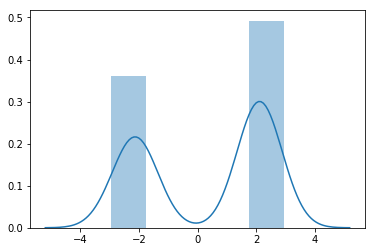

In [44]:
sns.distplot(z)

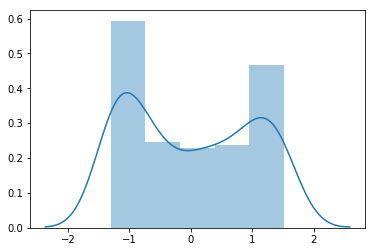

In [45]:
sns.distplot(x_std)

In [47]:
mgwr_model.aic

1037.4901938225476

In [48]:
optim_model.aic

331.3125681122599